# 목적
* 텐서플로우 2를 이용하여 Grad-CAM++ 구현 과정을 하나씩 뜯어보자.
* Grad-CAM 은 이미지 내에 특정 클래스에 해당하는 오브젝트가 여러 개 있을 때, 클래스 분류에 해당하는 오브젝트를 제대로 시각화 못하는 문제가 있음
* 시각화를 좀 더 잘 할 수 있는 기술을 제안 함

In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import urllib3
urllib3.disable_warnings()
import cv2

%matplotlib inline

In [2]:
print(tf.__version__)
print(tfds.__version__)

2.2.0
3.1.0


## 상수

In [3]:
EPOCHS = 15
BATCH_SIZE = 2**7

## 데이터 준비
* imagenet 데이터 중에서 제일 분류 잘 되는 데이터 일부를 가져다 쓰자.

In [4]:
ds = tfds.load('imagenette/160px-v2')

In [5]:
X_train, y_train = [], []
for x in ds['train']:
    img = np.array(Image.fromarray(x['image'].numpy()).resize((160,160)))
    X_train.append(img)
    y_train.append(x['label'])
    
X_test, y_test = [], []
for x in ds['validation']:
    img = np.array(Image.fromarray(x['image'].numpy()).resize((160,160)))
    X_test.append(img)
    y_test.append(x['label'])
    
X_train = np.array(X_train) / 255.
y_train = np.array(y_train)

X_test = np.array(X_test) / 255.
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9469, 160, 160, 3) (9469,)
(3925, 160, 160, 3) (3925,)


* 데이터 함 그려보자.

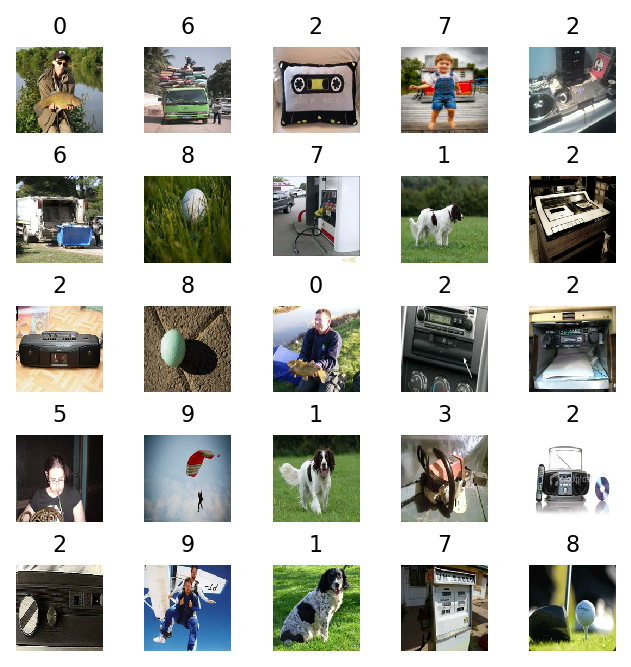

In [6]:
np.random.seed(0)
nrows, ncols = 5, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(5,5), dpi=160)
for i in range(nrows):
    for j in range(ncols):
        idx = np.random.randint(X_train.shape[0])
        ax[i][j].imshow(X_train[idx])
        ax[i][j].set_title(str(y_train[idx]), fontsize=10)
        ax[i][j].axis('off')
plt.subplots_adjust(hspace=.5)
plt.show()

In [7]:
train_dataset = tf.data.Dataset.\
            from_tensor_slices((X_train, y_train)).\
            shuffle(True).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.\
            from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

## 모델 불러오기

In [8]:
from tensorflow.keras import models, layers, losses, optimizers, metrics

In [9]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(160,160,3), include_top=False, weights='imagenet')

class Model(models.Model):
    def __init__(self,base_model):
        super(Model,self).__init__()
        self.base_model = base_model
        self.top_layer = models.Sequential([
            layers.Dense(10),
            layers.Activation(tf.nn.softmax),
        ])
        
    def call(self,inputs,training=False):
        x = self.base_model(inputs, training=training)
        x = layers.Flatten()(x)
        outputs = self.top_layer(x, training=training)
        return outputs
        
model = Model(mobilenetv2)
model.build((None, 160, 160, 3))

* 사전 학습 된거 좀만 더 트레이닝

In [10]:
opt = optimizers.Adam(learning_rate=1e-4)
scc = losses.SparseCategoricalCrossentropy()
metric = metrics.SparseCategoricalAccuracy()
loss = metrics.Mean()
acc = metrics.Mean()

In [11]:
%%time
for e in range(EPOCHS):
    start = time.time()
    for inputs in train_dataset:
        _x, _y = inputs
        with tf.GradientTape() as t:
            _y_pred = model(_x)
            _loss = scc(_y, _y_pred)
        grads = t.gradient(_loss, model.trainable_variables)
        opt.apply_gradients(list(zip(grads, model.trainable_variables)))
        loss.update_state(_loss)
        acc.update_state(metric(_y, _y_pred))
    print(f"{e+1}/{EPOCHS} loss:{loss.result():.8f} acc:{acc.result()*100:.2f}% {time.time()-start:.2f} sec/epoch")
    loss.reset_states()
    acc.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



1/15 loss:0.37423173 acc:76.83% 25.95 sec/epoch
2/15 loss:0.07845713 acc:91.28% 24.59 sec/epoch
3/15 loss:0.06171030 acc:94.02% 24.52 sec/epoch
4/15 loss:0.03229292 acc:95.26% 24.61 sec/epoch
5/15 loss:0.02814293 acc:96.08% 24.66 sec/epoch
6/15 loss:0.00990579 acc:96.70% 24.99 sec/epoch
7/15 loss:0.00641087 acc:97.17% 25.13 sec/epoch
8/15 loss:0.00428662 acc:97.54% 25.31 sec/epoch
9/15 loss:0.01552275 acc:97.79% 25.28 sec/epoch
10/15 loss:0.00895005 acc:97.98% 24.96 sec/epoch
11/15 loss:0.01000777 acc:98.15% 25.14 sec/epoch
12/15 loss:0.04233586 acc:98.24% 25.10 sec/epoch
13/15 loss:0.03959411 acc:98.27% 24.91 sec/epoch
14/15 loss:0.02214569 acc:98.33% 25.01 sec/epoch
15/15 loss:0.01039611 acc:98.41% 25.38 sec/epoch
CPU times: user 3min 1s, sys: 54.5 s, total: 3min 55s
Wall time: 6min 15s


## 모델 성능 확인

In [12]:
acc.reset_states()

for inputs in test_dataset:
    _x, _y = inputs
    _y_pred = model(_x)
    acc.update_state(metric(_y, _y_pred))
    
print(f"{acc.result()*100:.2f}%")

98.43%


## Grad-CAM 복습
### Notation
* Grad-CAM++ 논문의 노테이션이 조금 다르지만 통일성을 위해서 이놈 논문에서 그대로 적어보자.

**먼저 CAM 부터**
* 클래시피케이션 결과
$$
Y^c = \sum_k w_k^c \cdot \sum_i \sum_j A_{ij}^k \ \ \ \ (1)
$$
  * c: 클래스
  * k: feature map 번호
  * i, j: 뉴런 번호 인덱스
  * $A^k$: global averaged pooled last convolutional layer 의 feature map
  * 위 수식에서 $w_k^c$ 를 추가 학습 시켜주어야 함  
* Saliency map
$$
L^c_{ij} = \sum_k w_k^c \cdot A^k_{ij} \ \ \ \ (2)
$$
* 이 CAM 의 한계: GAP의 영향력만 체크할 수 있고, linear classifier 를 추가로 학습해주어야 함

**Grad-CAM에서**
* CAM의 한계 극복을 위함
* 클래스 c에 대한 특정 feature map $A^k$으로부터  $w_k^c$ 는
$$
w_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial Y^c}{\partial A^k_{ij}} \ \ \ \ (3)
$$
  * Z: activation map 내의 픽셀 개수 (상수)
* 이놈은 미분 가능한 deep CNN 모델 어떤 거든 쓸 수 있음
* 근데 이것도 단점이 있다. 동일 클래스에 해당하는 여러 오브젝트가 있으면 이를 잘 못 나타냄

## Grad-CAM++ (intuition)
* activation map $A^k_{ij}$에 특정 패턴이 있으면 1, 아니면 0이라고 한다.
* 그래서 어느 feature map 의 특정 픽셀이 오브젝트 있다는 영향을 크게 주면 그 픽셀 값은 커야 한다.
* 그래서 activation map 미분한 걸 아래처럼 표현할 수 있다.
\begin{aligned}
\frac{\partial y^c}{\partial A^k_{ij}} & = 1 \mbox{   if } A^k_{ij}=1\\
& = 0 \mbox{    if } A^k_{ij}=0 \ \ \ \ (4)
\end{aligned}

* 기계적으로 (4) 를 (3) 에 대입해보면 Z가 고정된 상수라서 분자가 작은 값이 나오면 분류에 영향 적게 주는 놈 처럼 되도록 해버림 (논문의 Fig. 2 보기)
* Grad-CAM++ 에서는 이를 해결하기 위해서 식 (3)을 아래처럼 다시 만듦
$$
w_k^c = \sum_i \sum_j \alpha_{ij}^{kc} \cdot relu (\frac{\partial Y^c}{\partial A^k_{ij}}) \ \ \ \ (5)
$$
* $\alpha^{kc}_{ij}$ : 클래스 c에 대하여 feature map $A^k$ 의 픽셀 별 기울기로 만든 계수
* 즉
\begin{aligned}
\alpha_{ij}^{kc} & = \frac{1}{\sum_{l,m} \frac{\partial y^c}{\partial A^k_{lm}}} \mbox{   if  } \frac{\partial y^c}{\partial A^k_{ij}} = 1\\
& = 0 \mbox{   otherwise } \ \ \ \ (6)
\end{aligned}

* 상수 Z 로 나눠버리는 것과 달리 매 픽셀마다 동일한 중요도로 표현이 됨

* (5) 에서는 양의 그레디언트만 고려한다.

## Grad-CAM++ (method)

* 식(1)에 (5) 대입 (i,j 인덱스 헷갈리니깐 a,b 로 씀)
$$
Y^c = \sum_k \big\{ \sum_a \sum_b \alpha_{ab}^{kc} \cdot relu \big(\frac{\partial Y^c}{\partial A^k_{ab}}\big) \big\} \big[\sum_i \sum_j A^k_{ij}\big] \ \ \ \ (7)
$$

* 양변을 k번째 activation map 으로 미분하되 있으면 헷갈리기만 하는 relu 는 미리 없애고 미분하자.
* $\frac{d}{dx} f(x)x = f(x) + f'(x)x$ 꼴로 미분한다. 일단 $\alpha$는 상수처럼 생각하고 있자.
* $x = A^k_{ij}$
* $f(x) = \alpha^{kc}_{ab}\cdot \frac{\partial Y^c}{\partial A^k_{ab}}$

* $k, a, b, i,j$ 인덱스들이 있어서 헷갈리지만, 핵심은 $(i,j)$ 로 미분한다는 점을 주의하자.
* 제일 뒤 $A_{ij}^k$ 날아가고 첫째 항 나온다.
* 둘째 항 구하는 것이 헷갈릴 수 있는데, (7)에서 오른쪽 $\sum_i \sum_j A^k_{ij}$의 $i,j$ 가 실은 그냥 $a, b$ 여야 함
* 그래서 $x\cdot f'(x)$ 꼴로 미분한 결과는 아래와 같다.
$$
\frac{\partial Y^c}{\partial A^k_{ij}} = \sum_a \sum_b \alpha_{ab}^{kc} \cdot \frac{\partial Y^c}{\partial A^k_{ab}} + \sum_a \sum_b A^k_{ab} \big\{ \alpha_{ij}^{kc} \cdot \frac{\partial^2 Y^2}{(\partial A^k_{ij})^2} \big\} \ \ \ \ (8)
$$

* 미분을 한 번 더 해준다. 왜냐면?
* 왼쪽 항은 걍 미분하면 되고, 오른쪽 항은 위에서 했던 것과 동일한 방법으로 미분하면 아래와 같은 결과가 나온다.
$$
\frac{\partial^2 Y^c}{(\partial A^k_{ij})^2} = 2\cdot \alpha^{kc}_{ij} \cdot \frac{\partial^2 Y^c}{(\partial A^k_{ij})^2} + \sum_a \sum_b A^k_{ab} \big\{ \alpha^{kc}_{ij} \cdot \frac{\partial^3 Y^c}{(\partial A^k_{ij})^3} \big\} \ \ \ \ (9)
$$

* 이제 $\alpha$에 대해서 정리해주고
$$
\alpha^{kc}_{ij} = \frac{\frac{\partial^2 Y^c}{(\partial A^k_{ij})^2}}{2\frac{\partial^2 Y^c}{(\partial A^k_{ij})^2}+\sum_a \sum_b A^k_{ab}\big\{ \frac{\partial^3 Y^c}{(\partial A^k_{ij})^3} \big\}} \ \ \ \ (10)
$$

* 이 $\alpha$ 를 (5) 에 대입해주자.
$$
w^c_k = \sum_i \sum_j \big[ \frac{\frac{\partial^2 Y^c}{(\partial A^k_{ij})^2}}{ 2\frac{\partial^2 Y^c}{(\partial A^k_{ij})^2} + \sum_a \sum_b A^k_{ab} \big\{ \frac{\partial^3 Y^c}{(\partial A^k_{ij})^3} \big\} } \big] \cdot relu \big( \frac{\partial Y^c}{\partial A^k_{ij}} \big) \ \ \ \ (11)
$$

* Grad-CAM 이랑 비교해보면 여기서 그냥 $\alpha= {1 \over Z}$ 해주면 그 놈이 Grad-CAM 이 되는 것임
* 즉 Grad-CAM++ 는 Grad-CAM 의 일반적인 버전

## 구현
[03-GradCAM.ipynb](./03-GradCAM.ipynb) 를 보았다면 거기서는 saliency map 을 그리기 위해서 $\alpha$ 를 구해서 썼다. 그게 여기서는 그냥 $w$임. 똑같은 의미지만 노테이션만 다름

이 튜토리얼에서도 예제 하나로 먼저 구현해보자. 그리고 나서 일반적으로 쓸 수 있도록 함수형태로 만들어보자.

Grad-CAM++ 에서는 미분이 최대 세 번까지 필요하기 때문에 텐서플로우2를 이용해서 이를 구현하려면 GradientTape를 잘 써야 한다. 다양한 사용 예제는 [링크](https://www.tensorflow.org/api_docs/python/tf/GradientTape)를 참고하자.

In [13]:
image = X_train[:1]
c = 2

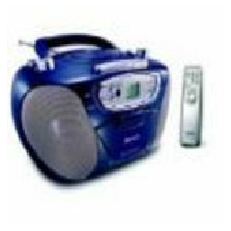

In [14]:
plt.imshow(np.squeeze(image))
plt.axis('off')
plt.show()

텐서플로우2의 GradientTape 특징은 미분대상이 뭐든지 간에 미분하려는 놈의 shape을 그대로 따라가 준다는 것이다.

In [15]:
with tf.GradientTape() as ttt:
    with tf.GradientTape() as tt:
        with tf.GradientTape() as t:
            _A = model.layers[0](image)
            print('미분 하는 놈 A', _A.shape)
            x = layers.Flatten()(_A)
            _y = model.layers[1].layers[0](x)
            print('미분 당할 놈 y', _y.shape)

relu = tf.nn.relu(t.gradient(_y, _A))
print('한번 미분', relu.shape)

d2 = tt.gradient(_y, _A)
print('두번 미분', d2.shape)

d3 = ttt.gradient(_y, _A)
print('세번 미분', d3.shape)

미분 하는 놈 A (1, 5, 5, 1280)
미분 당할 놈 y (1, 10)
한번 미분 (1, 5, 5, 1280)
두번 미분 (1, 5, 5, 1280)
세번 미분 (1, 5, 5, 1280)


여기서 shape를 보고 알아야하는 것

shpae 은 (1, 5, 5, 1280) 튜플인데,
* 1 => batch size
* (5, 5) => (i, j) 개수
* 1280 => k 개수

$w_k^c$ 는 1280개가 나와야하는 것을 알 수 있다. 또한 $\sum_i \sum_j$ 는 axis 1과 2를 reduce sum 하면 되는 것을 알 수 있다. 그 전에 $\sum_i \sum_j$ 안의 곱은 (i, j)-wise multiplication 을 하면 된다.

연산 순서는 대괄호 연산 -> (i, j)-wise multiplication -> (i, j) 각각 방향으로 reduce sum

* 대괄호 연산
$$
\frac{  \frac{\partial^2 Y^c}{(\partial A^k_{ij})^2}  }{2 \frac{\partial^2 Y^c}  {(\partial A^k_{ij})^2} + \sum_a \sum_b A^k_{ab}\big\{ \frac{\partial^3 Y^c}{(\partial A^k_{ij})^3} \big\}}
$$

In [16]:
d3_sum = tf.reduce_sum(tf.reduce_sum(d3, axis=1), axis=1)

tf.math.add 랑 + 는 같음. 그리고 얘네는 broadcasting 을 지원한다. 즉, 아래 분모 연산에서 d3_sum 은 d2 의 shape 에 맞추어 알아서 원소 각각ㄱ에 덧셈해줌

In [17]:
denominator1 = d2 / (2 * d2 + d3_sum)
denominator1.shape

TensorShape([1, 5, 5, 1280])

In [18]:
term1 = d2 / denominator1
term1.shape

TensorShape([1, 5, 5, 1280])

* relu 텀 연산은 위에서 이미 했다.
$$
relu \big( \frac{\partial Y^c}{\partial A^k_{ij}} \big)
$$

그래서 $\sum_i \sum_j$ 안에 들어갈 요소는

In [19]:
term = tf.math.multiply(term1, relu)
term.shape

TensorShape([1, 5, 5, 1280])

$w_k^c$ 를 k(=1280)개 구하려면 reduce sum 만 해주면 끝

In [20]:
w = tf.reduce_sum(tf.reduce_sum(term, axis=1), axis=1)
w.shape

TensorShape([1, 1280])

Saliency map 을 구하기 위해서 activation map 과 w를 k방향으로 더해주면 됨

위에서 했던 것과 같은 방법으로 먼저 w와 A를 곱(broadcasting 알아서 됨)해주고, k방향 reduce sum 하면 됨 (tf.math.multiply 랑 * 랑 같음)

In [21]:
wA = w * _A
wA.shape

TensorShape([1, 5, 5, 1280])

In [22]:
L = tf.reduce_sum(wA, axis=-1)
L.shape

TensorShape([1, 5, 5])

## 시각화

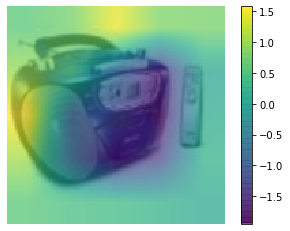

In [23]:
L_ = cv2.resize(np.squeeze(L), (160, 160))
plt.imshow(np.squeeze(image))
plt.imshow(L_, alpha=.7)
plt.axis('off')
plt.colorbar()
plt.show()

## Grad CAM++ 취합

In [24]:
def get_gradcam(image, c, model=model):
    with tf.GradientTape() as ttt:
        with tf.GradientTape() as tt:
            with tf.GradientTape() as t:
                _A = model.layers[0](image)
                x = layers.Flatten()(_A)
                _y = model.layers[1].layers[0](x)

    relu = tf.nn.relu(t.gradient(_y, _A))
    d2 = tt.gradient(_y, _A)
    d3 = ttt.gradient(_y, _A)
    
    d3_sum = tf.reduce_sum(tf.reduce_sum(d3, axis=1), axis=1)
    denominator1 = d2 / (2 * d2 + d3_sum)
    term1 = d2 / denominator1
    term = tf.math.multiply(term1, relu)
    w = tf.reduce_sum(tf.reduce_sum(term, axis=1), axis=1)
    wA = w * _A
    L = tf.reduce_sum(wA, axis=-1)
    return cv2.resize(np.squeeze(L), np.squeeze(image).shape[:2])

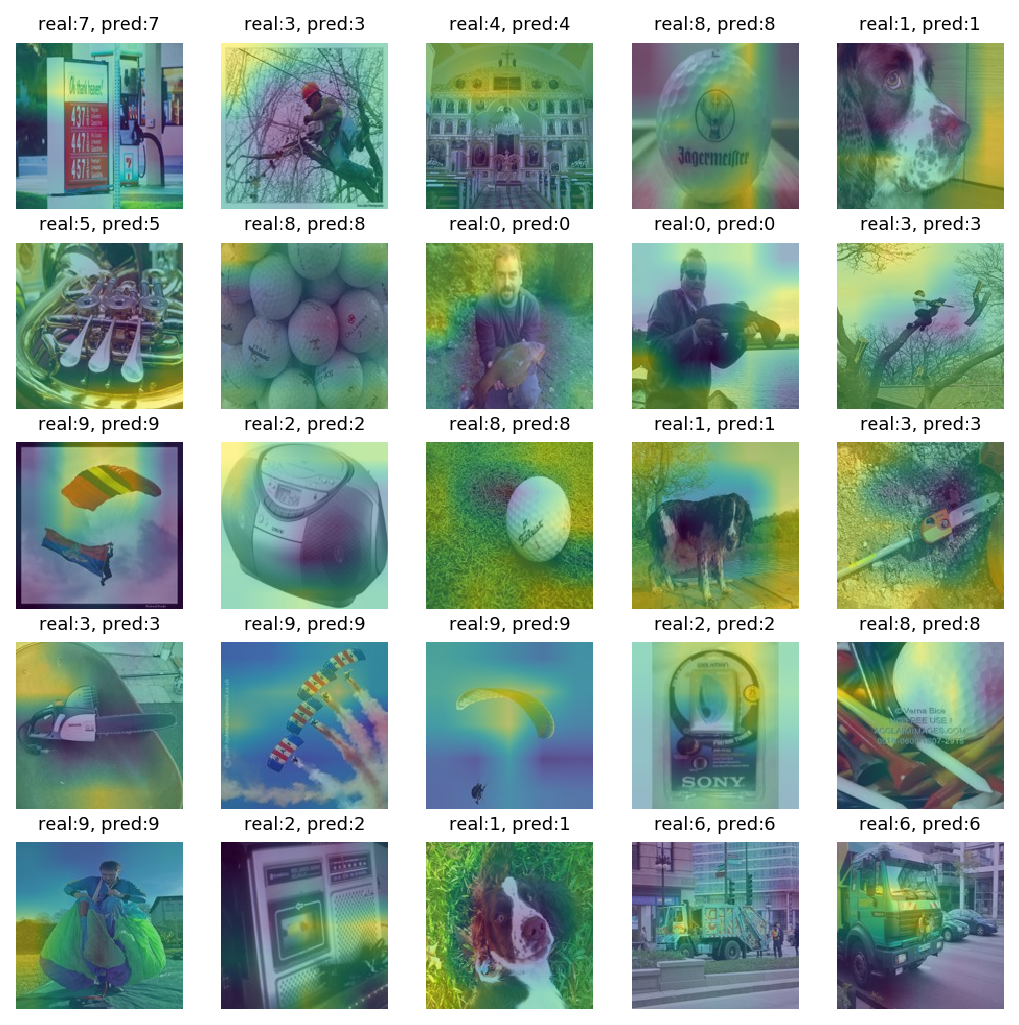

In [27]:
np.random.seed(0)
nrows = 5; ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(8, 8), dpi=160)
for i in range(nrows):
    for j in range(ncols):
        idx = np.random.randint(X_test.shape[0])
        image = X_test[idx:idx+1]
        c = y_test[idx]
        gradcam = get_gradcam(image, c)
        ax[i][j].imshow(np.squeeze(image))
        ax[i][j].imshow(gradcam, alpha=.5)
        ax[i][j].axis('off')
        ax[i][j].set_title(f"real:{c}, pred:{np.argmax(model(image))}", fontsize=8)
plt.show()